# Data Processing And Preparation

---

In this notebook, we are going to process the data put at our disposal and prepare it to be used for training by [**Detectron2**](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/): Indeed, **Detectron2** has been developed by Facebook to meet the research needs of Facebook AI and to provide the foundation for object detection (or image segmentation, like here) in production use cases at Facebook, therefore, it appears as a good candidate to tackle the problem that Severstal and Kaggle propose to study.

For that, we will need to constitute consistent training and testing datasets thanks to the training images that have been provided.

As always, the prerequisite step consists on loading the appropriate packages to perform our work:

In [1]:
# Needed packages:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cv2, json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from shutil import copyfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from utils import rle_to_mask, calculate_nb_defects_in_mask, basic_image_augmentation

---

## Constitute training and testing datasets

In this section, we are going to constitute training and testing datasets from the training images that have been provided.

For that, we are going to follow four steps:
* Create two folders for receiving the two datasets;
* Put all multi-labels images in the testing dataset;
* Separate the remaining images betweeen training and testing datasets following classical proportion (80%/20%) and accordingly to defect type repartition;
* Write two CSV files describing all necessary information corresponding to training and testing datasets.

### First step

In [2]:
# Create training and testing folders:
!mkdir ../data/training_ds ../data/testing_ds

### Second step

In [3]:
# Load the data:
train = pd.read_csv("../data/train.csv")

# Check basic info:
print("*** Some basic info:")
print("'train' has {} data points with {} variables each.".format(*train.shape))
print("'train' counts {} missing values.".format(train.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(train.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(train.tail(n=10))

*** Some basic info:
'train' has 7095 data points with 3 variables each.
'train' counts 0 missing values.

*** First lines:


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...



*** Last lines:


,ImageId,ClassId,EncodedPixels
7085,ff9923932.jpg,3,352770 158 353026 180 353282 192 353538 187 35...
7086,ff9d46e95.jpg,4,326401 4 326658 9 326915 12 327172 13 327429 1...
7087,ffb48ee43.jpg,3,38657 43 38913 128 39169 213 39425 2303 41751 ...
7088,ffbd081d5.jpg,3,280587 11 280841 33 281095 55 281350 76 281604...
7089,ffc9fdf70.jpg,3,306787 4 307025 2 307041 6 307099 4 307280 5 3...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...
7094,ffffd67df.jpg,3,30931 43 31103 127 31275 211 31489 253 31745 2...


All is OK!

In [4]:
# Initialize working dataframe:
working = train.copy()

In [5]:
# Remove all multi-labels images:
working.drop_duplicates(subset=['ImageId'], keep=False, inplace=True)

# Check operation result:
nb_rows = working.shape[0]
nb_mono_label_images = len(working['ImageId'].unique().tolist())
if nb_rows == nb_mono_label_images:
    res = 'OK!'
else:
    res = 'KO...'

# Print result:
print("*** Check operation result:")
print("- Current working dataframe counts {} rows.".format(nb_rows))
print("- Current working dataframe counts {} mono-label images.".format(nb_mono_label_images))
print("\nThe operation is {}".format(res))

*** Check operation result:
- Current working dataframe counts 6239 rows.
- Current working dataframe counts 6239 mono-label images.

The operation is OK!


### Third step

In [6]:
# Create shuffled and stratified images repartition:

# Separate "target" from "feature":
target = working['ClassId']
feature = working.drop(['ClassId', 'EncodedPixels'], axis=1)

# Extract feature:
extracted_feature = feature.values

# Encode target:
le = LabelEncoder()
le_defect_types = le.fit(target)
encoded_target = le_defect_types.transform(target)

# Shuffle, stratify and split:
train_img, test_img, train_lab, test_lab = train_test_split(extracted_feature,
                                                            encoded_target,
                                                            test_size=0.2,
                                                            stratify=encoded_target,
                                                            random_state=42)

In [7]:
# Check results:

# Create images training list:
train_img_lst = []
for img in train_img.tolist():
    train_img_lst.append(img[0])

# Create images testing list:
test_img_lst = []
for img in test_img.tolist():
    test_img_lst.append(img[0])

# Get stats on training labels repartition:
train_lab_lst = train_lab.tolist()
nb_dt_1_train, nb_dt_2_train, nb_dt_3_train, nb_dt_4_train = 0, 0, 0, 0
for lab in train_lab_lst:
    if lab == 0:
        nb_dt_1_train += 1
    if lab == 1:
        nb_dt_2_train += 1
    if lab == 2:
        nb_dt_3_train += 1
    if lab == 3:
        nb_dt_4_train += 1
        
# Get stats on training labels repartition:
test_lab_lst = test_lab.tolist()
nb_dt_1_test, nb_dt_2_test, nb_dt_3_test, nb_dt_4_test = 0, 0, 0, 0
for lab in test_lab_lst:
    if lab == 0:
        nb_dt_1_test += 1
    if lab == 1:
        nb_dt_2_test += 1
    if lab == 2:
        nb_dt_3_test += 1
    if lab == 3:
        nb_dt_4_test += 1

# Print results:
print("*** Check results:")
print("- Current training dataframe counts {} images (prop: {:.2f}%)".format(len(train_img_lst),
    float(len(train_img_lst))/nb_rows*100.))
print("- Current testing dataframe counts {} images (prop: {:.2f}%)".format(len(test_img_lst),
    float(len(test_img_lst))/nb_rows*100.))
print("- Current training dataframe counts {} type 1 defect images (prop: {:.2f}%)".format(nb_dt_1_train,
    float(nb_dt_1_train)/len(train_lab_lst)*100.))
print("- Current testing dataframe counts {} type 1 defect images (prop: {:.2f}%)".format(nb_dt_1_test,
    float(nb_dt_1_test)/len(test_lab_lst)*100.))
print("- Current training dataframe counts {} type 2 defect images (prop: {:.2f}%)".format(nb_dt_2_train,
    float(nb_dt_2_train)/len(train_lab_lst)*100.))
print("- Current testing dataframe counts {} type 2 defect images (prop: {:.2f}%)".format(nb_dt_2_test,
    float(nb_dt_2_test)/len(test_lab_lst)*100.))
print("- Current training dataframe counts {} type 3 defect images (prop: {:.2f}%)".format(nb_dt_3_train,
    float(nb_dt_3_train)/len(train_lab_lst)*100.))
print("- Current testing dataframe counts {} type 3 defect images (prop: {:.2f}%)".format(nb_dt_3_test,
    float(nb_dt_3_test)/len(test_lab_lst)*100.))
print("- Current training dataframe counts {} type 4 defect images (prop: {:.2f}%)".format(nb_dt_4_train,
    float(nb_dt_4_train)/len(train_lab_lst)*100.))
print("- Current testing dataframe counts {} type 4 defect images (prop: {:.2f}%)".format(nb_dt_4_test,
    float(nb_dt_4_test)/len(test_lab_lst)*100.))

*** Check results:
- Current training dataframe counts 4991 images (prop: 80.00%)
- Current testing dataframe counts 1248 images (prop: 20.00%)
- Current training dataframe counts 615 type 1 defect images (prop: 12.32%)
- Current testing dataframe counts 154 type 1 defect images (prop: 12.34%)
- Current training dataframe counts 156 type 2 defect images (prop: 3.13%)
- Current testing dataframe counts 39 type 2 defect images (prop: 3.12%)
- Current training dataframe counts 3807 type 3 defect images (prop: 76.28%)
- Current testing dataframe counts 952 type 3 defect images (prop: 76.28%)
- Current training dataframe counts 413 type 4 defect images (prop: 8.27%)
- Current testing dataframe counts 103 type 4 defect images (prop: 8.25%)


Once again, all is OK!

In [8]:
# Enhance training dataframe:

# Add number of defects per mask:
train_enhanced = calculate_nb_defects_in_mask(train)

# Add destination folder:
train_enhanced['DestFolder'] = 'testing'
for idx, row in train_enhanced.iterrows():
    if row['ImageId'] in train_img_lst:
        train_enhanced['DestFolder'].loc[idx] = 'training'
        
# Check basic info:
print("*** Some basic info:")
print("'train_enhanced' has {} data points with {} variables each.".format(*train_enhanced.shape))
print("'train_enhanced' counts {} missing values.".format(train_enhanced.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(train_enhanced.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(train_enhanced.tail(n=10))

/Users/mrksinant/Documents/miniconda3/envs/Severstal/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


*** Some basic info:
'train_enhanced' has 7095 data points with 5 variables each.
'train_enhanced' counts 0 missing values.

*** First lines:


,ImageId,ClassId,EncodedPixels,NbDefects,DestFolder
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,5,training
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,2,training
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,10,testing
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,2,training
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1,testing
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,6,testing
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...,2,testing
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...,2,training
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...,1,testing
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...,1,testing



*** Last lines:


,ImageId,ClassId,EncodedPixels,NbDefects,DestFolder
7085,ff9923932.jpg,3,352770 158 353026 180 353282 192 353538 187 35...,2,training
7086,ff9d46e95.jpg,4,326401 4 326658 9 326915 12 327172 13 327429 1...,2,training
7087,ffb48ee43.jpg,3,38657 43 38913 128 39169 213 39425 2303 41751 ...,3,training
7088,ffbd081d5.jpg,3,280587 11 280841 33 281095 55 281350 76 281604...,2,training
7089,ffc9fdf70.jpg,3,306787 4 307025 2 307041 6 307099 4 307280 5 3...,8,testing
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...,2,training
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...,2,training
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...,1,training
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...,4,testing
7094,ffffd67df.jpg,3,30931 43 31103 127 31275 211 31489 253 31745 2...,1,training


In [9]:
# Populate training and testing datasets:
for img in train_enhanced['ImageId'].unique().tolist():
    source = '../data/train_images/' + img
    if img in train_img_lst:
        destination = '../data/training_ds/' + img
        copyfile(source, destination)
    else:
        destination = '../data/testing_ds/' + img
        copyfile(source, destination)

In [10]:
# Check operation results:
print("*** Number of images in the training folder:")
!find ../data/training_ds -type f -name '*.jpg'  | wc -l
print("\n*** Number of images in the testing folder:")
!find ../data/testing_ds -type f -name '*.jpg'  | wc -l

*** Number of images in the training folder:
    4991

*** Number of images in the testing folder:
    1675


All is OK!

In [11]:
# Save our work:
train_enhanced.to_csv("../data/train_enhanced.csv", header=True, index=False)

### Four step

We are going to begin with training dataset.

In [12]:
# Initialize training dataset description dataframe:
training_ds = train_enhanced.copy()

In [13]:
# Delete rows corresponding to testing dataset:
training_ds.drop(training_ds.loc[training_ds['DestFolder']=='testing'].index, inplace=True)

In [14]:
# Quick check:
print("*** Some basic info:")
print("'training_ds' has {} data points with {} variables each.".format(*training_ds.shape))
print("'training_ds' counts {} missing values.".format(training_ds.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(training_ds.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(training_ds.tail(n=10))

*** Some basic info:
'training_ds' has 4991 data points with 5 variables each.
'training_ds' counts 0 missing values.

*** First lines:


,ImageId,ClassId,EncodedPixels,NbDefects,DestFolder
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,5,training
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,2,training
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,2,training
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...,2,training
10,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...,2,training
12,005d86c25.jpg,3,331 18 587 53 843 89 1099 124 1355 159 1611 17...,2,training
13,005f02e20.jpg,3,318652 8 318863 6 318903 17 319114 15 319158 2...,1,training
14,005f19695.jpg,3,123137 7 123393 19 123649 32 123905 44 124161 ...,6,training
15,008621629.jpg,4,215548 3 215798 9 216051 12 216306 13 216560 1...,2,training
16,0088260da.jpg,3,26044 13 26283 40 26522 67 26762 92 27001 119 ...,4,training



*** Last lines:


,ImageId,ClassId,EncodedPixels,NbDefects,DestFolder
7080,ff6cc90ca.jpg,3,270550 43 270722 127 270894 211 271107 254 271...,2,training
7083,ff933e271.jpg,3,149505 32 149761 96 150017 160 150273 224 1505...,4,training
7085,ff9923932.jpg,3,352770 158 353026 180 353282 192 353538 187 35...,2,training
7086,ff9d46e95.jpg,4,326401 4 326658 9 326915 12 327172 13 327429 1...,2,training
7087,ffb48ee43.jpg,3,38657 43 38913 128 39169 213 39425 2303 41751 ...,3,training
7088,ffbd081d5.jpg,3,280587 11 280841 33 281095 55 281350 76 281604...,2,training
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...,2,training
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...,2,training
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...,1,training
7094,ffffd67df.jpg,3,30931 43 31103 127 31275 211 31489 253 31745 2...,1,training


In [15]:
# Drop here useless columns:
training_ds.drop(['NbDefects', 'DestFolder'], axis=1, inplace=True)

In [16]:
# Quick check:
print("*** Some basic info:")
print("'training_ds' has {} data points with {} variables each.".format(*training_ds.shape))
print("'training_ds' counts {} missing values.".format(training_ds.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(training_ds.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(training_ds.tail(n=10))

*** Some basic info:
'training_ds' has 4991 data points with 3 variables each.
'training_ds' counts 0 missing values.

*** First lines:


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
10,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
12,005d86c25.jpg,3,331 18 587 53 843 89 1099 124 1355 159 1611 17...
13,005f02e20.jpg,3,318652 8 318863 6 318903 17 319114 15 319158 2...
14,005f19695.jpg,3,123137 7 123393 19 123649 32 123905 44 124161 ...
15,008621629.jpg,4,215548 3 215798 9 216051 12 216306 13 216560 1...
16,0088260da.jpg,3,26044 13 26283 40 26522 67 26762 92 27001 119 ...



*** Last lines:


,ImageId,ClassId,EncodedPixels
7080,ff6cc90ca.jpg,3,270550 43 270722 127 270894 211 271107 254 271...
7083,ff933e271.jpg,3,149505 32 149761 96 150017 160 150273 224 1505...
7085,ff9923932.jpg,3,352770 158 353026 180 353282 192 353538 187 35...
7086,ff9d46e95.jpg,4,326401 4 326658 9 326915 12 327172 13 327429 1...
7087,ffb48ee43.jpg,3,38657 43 38913 128 39169 213 39425 2303 41751 ...
7088,ffbd081d5.jpg,3,280587 11 280841 33 281095 55 281350 76 281604...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7094,ffffd67df.jpg,3,30931 43 31103 127 31275 211 31489 253 31745 2...


All is OK!

In [17]:
# Save our work:
training_ds.to_csv("../data/training_ds/annotations.csv", header=True, index=False)

We can now terminate with testing dataset, following the same process.

In [18]:
# Initialize testing dataset description dataframe:
testing_ds = train_enhanced.copy()

In [19]:
# Delete rows corresponding to training dataset:
testing_ds.drop(testing_ds.loc[testing_ds['DestFolder']=='training'].index, inplace=True)

In [20]:
# Quick check:
print("*** Some basic info:")
print("'testing_ds' has {} data points with {} variables each.".format(*testing_ds.shape))
print("'testing_ds' counts {} missing values.".format(testing_ds.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(testing_ds.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(testing_ds.tail(n=10))

*** Some basic info:
'testing_ds' has 2104 data points with 5 variables each.
'testing_ds' counts 0 missing values.

*** First lines:


,ImageId,ClassId,EncodedPixels,NbDefects,DestFolder
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,10,testing
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1,testing
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,6,testing
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...,2,testing
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...,1,testing
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...,1,testing
11,0046839bd.jpg,3,152926 1 153180 4 153434 6 153689 8 153943 11 ...,1,testing
18,008ef3d74.jpg,1,356336 4 356587 11 356838 18 357089 25 357340 ...,1,testing
19,008ef3d74.jpg,2,375439 5 375687 14 375935 24 376182 34 376430 ...,1,testing
21,00ac8372f.jpg,1,101742 3 101998 12 102253 19 102301 22 102509 ...,1,testing



*** Last lines:


,ImageId,ClassId,EncodedPixels,NbDefects,DestFolder
7066,feebe80d4.jpg,3,105911 10 106167 30 106423 40 106679 40 106935...,1,testing
7069,ff1020719.jpg,3,130714 8 130970 22 131226 37 131482 52 131738 ...,4,testing
7072,ff44fa556.jpg,3,286291 3 286545 7 286799 11 287053 15 287306 2...,2,testing
7078,ff6bfada2.jpg,3,123261 10 123507 28 123752 47 123997 66 124243...,2,testing
7079,ff6bfada2.jpg,4,90877 2 91131 4 91385 6 91638 9 91892 12 92146...,2,testing
7081,ff6e35e0a.jpg,1,366059 22 366273 64 366487 106 366700 149 3669...,1,testing
7082,ff6e35e0a.jpg,2,380118 43 380290 127 380462 211 380676 253 380...,1,testing
7084,ff96dfa95.jpg,3,37377 128 37633 3840 123361 32 123553 96 12374...,4,testing
7089,ffc9fdf70.jpg,3,306787 4 307025 2 307041 6 307099 4 307280 5 3...,8,testing
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...,4,testing


In [21]:
# Drop here useless columns:
testing_ds.drop(['NbDefects', 'DestFolder'], axis=1, inplace=True)

In [22]:
# Quick check:
print("*** Some basic info:")
print("'testing_ds' has {} data points with {} variables each.".format(*testing_ds.shape))
print("'testing_ds' counts {} missing values.".format(testing_ds.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(testing_ds.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(testing_ds.tail(n=10))

*** Some basic info:
'testing_ds' has 2104 data points with 3 variables each.
'testing_ds' counts 0 missing values.

*** First lines:


,ImageId,ClassId,EncodedPixels
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...
11,0046839bd.jpg,3,152926 1 153180 4 153434 6 153689 8 153943 11 ...
18,008ef3d74.jpg,1,356336 4 356587 11 356838 18 357089 25 357340 ...
19,008ef3d74.jpg,2,375439 5 375687 14 375935 24 376182 34 376430 ...
21,00ac8372f.jpg,1,101742 3 101998 12 102253 19 102301 22 102509 ...



*** Last lines:


,ImageId,ClassId,EncodedPixels
7066,feebe80d4.jpg,3,105911 10 106167 30 106423 40 106679 40 106935...
7069,ff1020719.jpg,3,130714 8 130970 22 131226 37 131482 52 131738 ...
7072,ff44fa556.jpg,3,286291 3 286545 7 286799 11 287053 15 287306 2...
7078,ff6bfada2.jpg,3,123261 10 123507 28 123752 47 123997 66 124243...
7079,ff6bfada2.jpg,4,90877 2 91131 4 91385 6 91638 9 91892 12 92146...
7081,ff6e35e0a.jpg,1,366059 22 366273 64 366487 106 366700 149 3669...
7082,ff6e35e0a.jpg,2,380118 43 380290 127 380462 211 380676 253 380...
7084,ff96dfa95.jpg,3,37377 128 37633 3840 123361 32 123553 96 12374...
7089,ffc9fdf70.jpg,3,306787 4 307025 2 307041 6 307099 4 307280 5 3...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


All is OK!

In [23]:
# Save our work:
testing_ds.to_csv("../data/testing_ds/annotations.csv", header=True, index=False)

---

## Appendix

We are not going to proceed this way in this study, but, to augment datasets (or to try to tackle the issue of unbalanced ones), it is possible to act, as it can be visualized below:

In [24]:
# Random example preparation:
image_ori = cv2.imread('../data/train_images/000f6bf48.jpg')
image_ori_mask = rle_to_mask(train[(train['ImageId']=='000f6bf48.jpg')]['EncodedPixels'].values[0])
image_ori_mask = np.ma.masked_where(image_ori_mask==0, image_ori_mask)
image_aug, image_aug_mask, image_aug_rle = basic_image_augmentation('000f6bf48.jpg', train)
image_aug_mask = np.ma.masked_where(image_aug_mask==0, image_aug_mask)

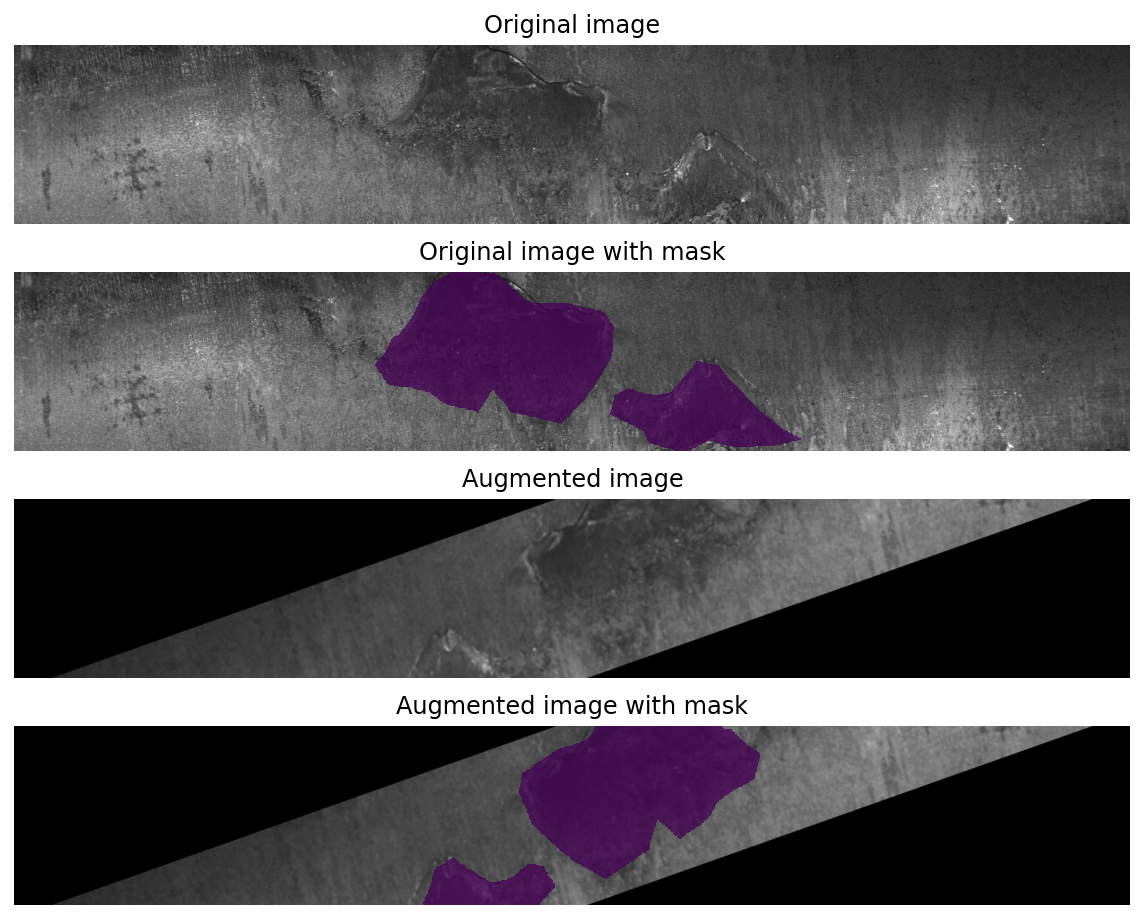

In [25]:
# Define the graph:
fig, axes = plt.subplots(4, figsize=(10, 8))

# Configuration of the graph:
axes[0].set_title("Original image")
axes[0].imshow(image_ori)
axes[0].axis('off')
axes[1].set_title("Original image with mask")
axes[1].imshow(image_ori)
axes[1].imshow(image_ori_mask, alpha=0.75)
axes[1].axis('off')
axes[2].set_title("Augmented image")
axes[2].imshow(image_aug)
axes[2].axis('off')
axes[3].set_title("Augmented image with mask")
axes[3].imshow(image_aug)
axes[3].imshow(image_aug_mask, alpha=0.75)
axes[3].axis('off')

# Save the graph:
fig.savefig('../graphs/augmented_image_illustration.png', bbox_inches='tight')